In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf
import keras
import keras_metrics as km
from keras import initializers

from keras.callbacks import TensorBoard
from keras import regularizers
from custom_callbacks import LrFinder
from custom_callbacks import CycleLearner
from custom_callbacks import reset_weights
from keras.callbacks import ModelCheckpoint
from time import time
from keras.layers import Input, Dense,Dropout,BatchNormalization,LSTM,GRU,Bidirectional,Conv2D, MaxPool2D, Flatten, GlobalAvgPool2D, GlobalMaxPool2D,merge,CuDNNGRU,CuDNNLSTM
from keras.models import Model,Sequential
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import RMSprop
from keras import backend as K
import math
import json

# Get the dictionary containing each metric and the loss for each epoch


Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3169198090280525997
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11893748532
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17073871410701042475
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [5]:
train_filepath = "train_workspace/"
animalList = ["Human","Pig","Chicken","Rat","Mouse","Dog"]
levelList = ["Strict","Relaxed","Intermediate"]
dataList = ["Ohnologs","No-Ohnologs","Paralogs"]
dataNameList = ["ohnologs","no-ohnologs","paralog"]
sns.set_style("darkgrid")

In [6]:
working_level = "Strict"
kmer_chosen = 8
type_chosen = "cdna"

dataset_complete = pd.read_pickle(train_filepath + working_level + "/datasets/2_paralog_dataset_complete-" + str(kmer_chosen) + "-" + type_chosen + ".pkl")
dataset_complete_soft = pd.read_pickle(train_filepath + working_level + "/datasets/3_paralog_dataset_complete-" + str(kmer_chosen) + "-" + type_chosen + ".pkl")

In [7]:
new_classes = []
for index, row in dataset_complete_soft.iterrows():
    if(row["Is_Ohnolog"] == 1):
        new_classes.append(1)
    else:
        if(row["Is_Paralog"] == 0):
            new_classes.append(0)
        else:
            new_classes.append(2)
dataset_complete_soft["Dup_Class"] = new_classes
dataset_complete_soft.head()

,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Is_Ohnolog,Is_Paralog,Sequence-1 GC,Sequence-1 Length,...,Embedding2_91,Embedding2_92,Embedding2_93,Embedding2_94,Embedding2_95,Embedding2_96,Embedding2_97,Embedding2_98,Embedding2_99,Dup_Class
0,0,0,1,0,0,0,1,0.0,0.429090,0.030467,...,35.407509,23.369914,8.144324,-26.702099,241.207709,-12.695194,-79.573883,121.379307,-69.633950,1
1,0,0,1,0,0,0,1,0.0,0.441268,0.053554,...,12.556002,23.217834,3.162621,-18.980361,204.830682,-20.962017,-61.163222,122.543777,-26.694989,1
2,0,0,1,0,0,0,1,0.0,0.357972,0.111632,...,-6.850837,12.314794,-3.387437,-5.403946,93.521862,4.187927,-35.880841,50.565405,-9.853733,1
3,0,0,1,0,0,0,1,0.0,0.684226,0.031676,...,68.287420,6.295047,37.820265,-33.841090,230.696114,-60.500167,-82.975793,174.224105,-111.569089,1
4,0,0,1,0,0,0,1,0.0,0.402629,0.018732,...,18.025175,13.675959,21.304353,-2.702105,162.972440,-8.209692,-46.736790,62.650600,-39.056701,1


In [8]:
new_classes = []
for index, row in dataset_complete.iterrows():
    if(row["Is_Ohnolog"] == 1):
        new_classes.append(1)
    else:
        if(row["Is_Paralog"] == 0):
            new_classes.append(0)
        else:
            new_classes.append(2)
dataset_complete["Dup_Class"] = new_classes
dataset_complete.head()

,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Is_Ohnolog,Is_Paralog,Sequence-1 GC,Sequence-1 Length,...,Embedding2_91,Embedding2_92,Embedding2_93,Embedding2_94,Embedding2_95,Embedding2_96,Embedding2_97,Embedding2_98,Embedding2_99,Dup_Class
0,0,0,1,0,0,0,1,0.0,0.429090,0.115183,...,35.407509,23.369914,8.144324,-26.702099,241.207709,-12.695194,-79.573883,121.379307,-69.633950,1
1,0,0,1,0,0,0,1,0.0,0.441268,0.202706,...,12.556002,23.217834,3.162621,-18.980361,204.830682,-20.962017,-61.163222,122.543777,-26.694989,1
2,0,0,1,0,0,0,1,0.0,0.357972,0.422880,...,-6.850837,12.314794,-3.387437,-5.403946,93.521862,4.187927,-35.880841,50.565405,-9.853733,1
3,0,0,1,0,0,0,1,0.0,0.684226,0.119763,...,68.287420,6.295047,37.820265,-33.841090,230.696114,-60.500167,-82.975793,174.224105,-111.569089,1
4,0,0,1,0,0,0,1,0.0,0.402629,0.070693,...,18.025175,13.675959,21.304353,-2.702105,162.972440,-8.209692,-46.736790,62.650600,-39.056701,1


## Start Designing

In [9]:
blast_columns = ["Percent Identical Matches","Aligment Length","Nr Mismatch","Nr Gap Open","Evalue","Bit Score"]

e_values_columns = ["Evalue_Total","Evalue_High","Evalue_Medium","Evalue_Low"]

blast_types = ["High","Medium","Low","Total"]
blast_col_Total = [i + "_Total" for i in blast_columns] 
blast_col_High = [i + "_High" for i in blast_columns]
blast_col_Medium = [i + "_Medium" for i in blast_columns]
blast_col_Low = [i + "_Low" for i in blast_columns]

blast_cols_levels = blast_col_High + blast_col_Medium + blast_col_Low
total_columns = (blast_col_High + blast_col_Medium + blast_col_Low + blast_col_Total + ["Nr Hits"])

non_training_meta_features = ["Sequence-1","Sequence-2","Sequence-1 Id","Sequence-1-Transcript Id","Sequence-2 Id","Sequence-2-Transcript Id","Sequence-1-Transcript-Version","Sequence-2-Transcript-Version"]

sequence_1_metadata = ["Sequence-1 GC","Sequence-1 Length","Sequence-1-Chromosome","Seq-1-Biotype_protein_coding"]
sequence_2_metadata = ["Sequence-2 GC","Sequence-2 Length","Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"]

sequence_1_metadata_diferential = ["Sequence-1 GC","Sequence-1 Length"]
sequence_2_metadata_diferential = ["Sequence-2 GC","Sequence-2 Length"]

sequence_1_metadata_categorical = ["Sequence-1-Chromosome","Seq-1-Biotype_protein_coding"]
sequence_2_metadata_categorical = ["Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"]

species_metadata = ["Specie_Chicken","Specie_Dog","Specie_Human","Specie_Mouse","Specie_Pig","Specie_Rat"]

emb_size = 100
if(type_chosen == "cdna2"):
    emb_size = 200
embedding_1_cols = ["Embedding1_" + str(i) for i in range(0,emb_size)]
embedding_2_cols = ["Embedding2_" + str(i) for i in range(0,emb_size)]

In [10]:
count_species = []
for species in species_metadata:
    count_species.append(len(dataset_complete[dataset_complete[species] == 1]))

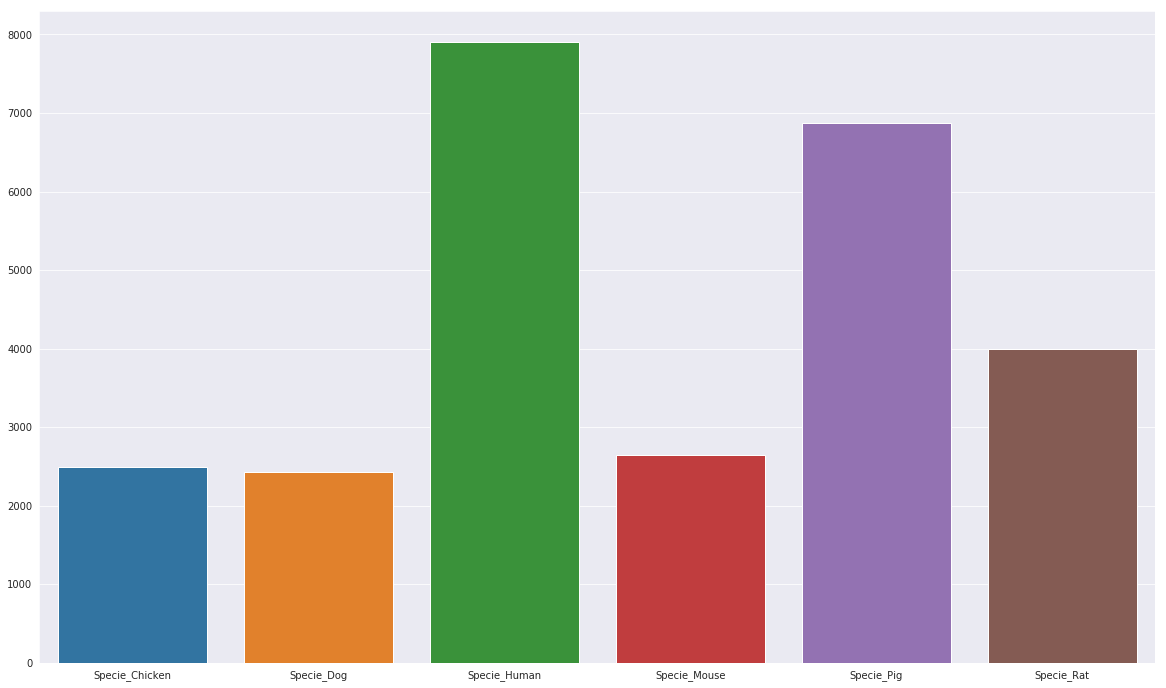

In [11]:
plt.subplots(figsize=(20,12))
sns.barplot(species_metadata,count_species)

In [12]:
dataset_complete_no_chicken = dataset_complete[dataset_complete["Specie_Chicken"] == 0]
dataset_complete_no_mouse =  dataset_complete[dataset_complete["Specie_Mouse"] == 0]
print(dataset_complete.shape)
print(dataset_complete_no_chicken.shape)

(26337, 243)
(23838, 243)


## Models

In [13]:
def get_train_val_test(df):
    df.sample(frac=1,random_state=7)
    df_train, df_test = train_test_split(df, test_size=0.2,random_state=9,stratify=df["Is_Ohnolog"])
    df_train, df_val = train_test_split(df_train, test_size=0.2,random_state=3,stratify=df_train["Is_Ohnolog"])
    return (df_train,df_val,df_test)

In [14]:
def get_train_val_test_soft(df):
    df.sample(frac=1,random_state=7)
    df_train, df_test = train_test_split(df, test_size=0.2,random_state=9,stratify=df["Dup_Class"])
    df_train, df_val = train_test_split(df_train, test_size=0.2,random_state=3,stratify=df_train["Dup_Class"])
    return (df_train,df_val,df_test)

In [15]:
def save_log(log,name):
    log_dict = log.history    
    json.dump(log_dict, open(train_filepath + working_level + "/model_run_history/" + name + ".json", 'w'))

In [16]:
def get_log(name):
     return json.load(open(train_filepath + working_level + "/model_run_history/" + name + ".json", 'r'))

In [17]:
class EpochLogger(keras.callbacks.Callback):
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}        

    def on_epoch_end(self, epoch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log_default = ''            
            metrics_log_main = ''            
            metrics_log_aux = ''            
            for (k, v) in self.metric_cache.items():
                val = v / self.display             
                if("main" in k):
                    if abs(val) > 1e-3:
                        metrics_log_main += ' - %s: %.4f' % (k, val)
                        continue      
                    else:
                        metrics_log_main += ' - %s: %.4e' % (k, val)
                        continue                    
                        
                if("aux" in k): 
                    if abs(val) > 1e-3:
                        metrics_log_aux += ' - %s: %.4f' % (k, val)
                        continue      
                    else:
                        metrics_log_aux += ' - %s: %.4e' % (k, val)
                        continue      
                        
                if abs(val) > 1e-3:
                        metrics_log_default += ' - %s: %.4f' % (k, val)
                else:
                        metrics_log_default += ' - %s: %.4e' % (k, val)                        
                    
            print('step: {}/{} ... {}'.format(self.step,
                                          self.params['epochs'],
                                          metrics_log_default + "\n" + metrics_log_main + "\n" + metrics_log_aux))
            self.metric_cache.clear()

## Levels

In [18]:
def show_results_level(model, log,x_test,x_emb_test,y_test,bs,metrics_used):
    metrics_names,metrics = (model.metrics_names,model.evaluate([x_emb_test.values,x_test.values],[y_test.values,y_test.values], batch_size=bs,verbose=False))
    count = 0
    for i in range(0,len(metrics)):
        print(f'{metrics_names[i]}     = {metrics[i]:.4f}')                
    nr_metrics = len(metrics_used)
    fig, axes = plt.subplots(2, nr_metrics, figsize=(18,8))   
    
    i = 0
    for metric in metrics_used:
        match_metrics = [model_metric.split('_')[0] for model_metric in metrics_names if metric in model_metric]
        print(match_metrics)
        if(metric == "loss"):
            match_metrics.remove("loss")
        for match in match_metrics:        
            if(i>=nr_metrics):
                axes[1][i-nr_metrics].plot(log[match + "_" + metric], label="Train")            
                axes[1][i-nr_metrics].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[1][i-nr_metrics].set_xlabel('epoch'); 
                axes[1][i-nr_metrics].set_ylabel(metric + "_" + match)                            
            else:
                axes[0][i].plot(log[match + "_" + metric], label="Train")            
                axes[0][i].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[0][i].set_xlabel('epoch'); 
                axes[0][i].set_ylabel(metric + "_" + match)                            
                
            i += 1            
    for ax in axes:
        for a in ax:
             a.legend()

In [19]:
def show_results_level_RNN(model, log,x_test,x_emb_test,y_test,bs,metrics_used):
    metrics_names,metrics = (model.metrics_names,model.evaluate([x_emb_test.values.reshape(x_emb_test.shape[0],x_emb_test.shape[1],1),x_test.values],[y_test.values,y_test.values], batch_size=bs,verbose=False))
    count = 0
    for i in range(0,len(metrics)):
        print(f'{metrics_names[i]}     = {metrics[i]:.4f}')                
    nr_metrics = len(metrics_used)
    fig, axes = plt.subplots(2, nr_metrics, figsize=(18,8))   
    
    i = 0
    for metric in metrics_used:
        match_metrics = [model_metric.split('_')[0] for model_metric in metrics_names if metric in model_metric]
        print(match_metrics)
        if(metric == "loss"):
            match_metrics.remove("loss")
        for match in match_metrics:        
            if(i>=nr_metrics):
                axes[1][i-nr_metrics].plot(log[match + "_" + metric], label="Train")            
                axes[1][i-nr_metrics].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[1][i-nr_metrics].set_xlabel('epoch'); 
                axes[1][i-nr_metrics].set_ylabel(metric + "_" + match)                            
            else:
                axes[0][i].plot(log[match + "_" + metric], label="Train")            
                axes[0][i].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[0][i].set_xlabel('epoch'); 
                axes[0][i].set_ylabel(metric + "_" + match)                            
                
            i += 1            
    for ax in axes:
        for a in ax:
             a.legend()

In [20]:
def level_model(df_meta_input,df_embeddings,name):    
    input_embedding = Input(shape=(len(df_embeddings.columns),), name='embedding_input')        
    emb_x = Dense(512, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.01))(input_embedding)    
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dropout(0.4)(emb_x)
    emb_x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)
    emb_x = Dropout(0.4)(emb_x)
    emb_x = Dense(256, activation='relu',use_bias = False,kernel_regularizer=regularizers.l2(0.01))(emb_x)    
    emb_x = Dropout(0.3)(emb_x)
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)
    emb_x = Dropout(0.3)(emb_x)
    emb_x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)    
    emb_x = Dropout(0.3)(emb_x)
    emb_x = Dense(32, activation='relu',use_bias = False)(emb_x)
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)        
    emb_x_out = Dense(1, activation='sigmoid',name="aux")(emb_x)
    
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x, meta_input])
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(1, activation='sigmoid',name="main")(x)

    # This creates a model that includes
    # the Input layer and three Dense layers                       
    model_created = Model(inputs=[input_embedding, meta_input], outputs=[emb_x_out,predictions])
    model_created.Name = name
    return model_created

In [21]:
def level_model_soft(df_meta_input,df_embeddings,name):    
    input_embedding = Input(shape=(len(df_embeddings.columns),), name='embedding_input')        
    emb_x = Dense(512, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.01))(input_embedding)    
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dropout(0.4)(emb_x)
    emb_x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)
    emb_x = Dropout(0.4)(emb_x)
    emb_x = Dense(256, activation='relu',use_bias = False,kernel_regularizer=regularizers.l2(0.01))(emb_x)    
    emb_x = Dropout(0.3)(emb_x)
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)
    emb_x = Dropout(0.3)(emb_x)
    emb_x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)    
    emb_x = Dropout(0.3)(emb_x)
    emb_x = Dense(32, activation='relu',use_bias = False)(emb_x)
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)        
    emb_x_out = Dense(3, activation='softmax',name="aux")(emb_x)
    
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x, meta_input])
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(3, activation='softmax',name="main")(x)

    # This creates a model that includes
    # the Input layer and three Dense layers                       
    model_created = Model(inputs=[input_embedding, meta_input], outputs=[emb_x_out,predictions])
    model_created.Name = name
    return model_created


In [22]:
def fit_model_level(train_x,train_emb_x,train_y,val_x,val_emb_x,val_y,model_train,n_epochs,optimizer,batchsize,loss_weigths,verb):
    tensorboard = TensorBoard(log_dir=train_filepath + working_level + "/board_logs/" + model_train.Name + "-" + "-{}".format(time()))
    checkpoint = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-check-{{epoch:02d}}-{{val_main_acc:.2f}}.hdf5".format(model_train.Name),save_weights_only=True, period = int(n_epochs/5))
    best_model_save = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-best.hdf5".format(model_train.Name), monitor='val_main_acc',save_weights_only=True,  save_best_only=True, mode='max')
    logger = EpochLogger(display=50)

    model_train.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy',km.binary_recall()],loss_weights=loss_weigths)
    size = len(train_emb_x)
    return model_train.fit([train_emb_x,train_x], y= [train_y,train_y],verbose = verb,validation_data=([val_emb_x,val_x],[val_y,val_y]),epochs = n_epochs,batch_size=batchsize,callbacks = [tensorboard,checkpoint,best_model_save,logger])  # starts training

In [23]:
def fit_model_level_soft(train_x,train_emb_x,train_y,val_x,val_emb_x,val_y,model_train,n_epochs,optimizer,batchsize,loss_weigths,verb):
    tensorboard = TensorBoard(log_dir=train_filepath + working_level + "/board_logs/" + model_train.Name + "-" + "-{}".format(time()))
    checkpoint = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-check-{{epoch:02d}}-{{val_main_acc:.2f}}.hdf5".format(model_train.Name),save_weights_only=True, period = int(n_epochs/5))
    best_model_save = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-best.hdf5".format(model_train.Name), monitor='val_main_acc',save_weights_only=True,  save_best_only=True, mode='max')
    logger = EpochLogger(display=25)

    model_train.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy',km.sparse_categorical_recall()],loss_weights=loss_weigths)
    size = len(train_emb_x)
    return model_train.fit([train_emb_x,train_x], y= [train_y,train_y],verbose = verb,validation_data=([val_emb_x,val_x],[val_y,val_y]),epochs = n_epochs,batch_size=batchsize,callbacks = [tensorboard,checkpoint,best_model_save,logger])  # starts training

In [24]:
df_train,df_val,df_test = get_train_val_test(dataset_complete_no_chicken)
df_train.head()

,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Is_Ohnolog,Is_Paralog,Sequence-1 GC,Sequence-1 Length,...,Embedding2_91,Embedding2_92,Embedding2_93,Embedding2_94,Embedding2_95,Embedding2_96,Embedding2_97,Embedding2_98,Embedding2_99,Dup_Class
12028,0,1,0,0,0,0,1,0.0,0.499075,0.554254,...,70.493156,-467.235377,-297.770580,-358.897289,-141.311865,-379.257467,134.625360,176.878456,-416.207631,1
6425,0,0,0,0,0,1,0,0.0,0.450886,0.019813,...,9.836120,-84.527801,-9.019162,-69.158747,9.692131,-101.924337,6.945799,10.244836,-91.662070,0
789,0,0,1,0,0,0,1,0.0,0.406405,0.305993,...,17.111708,6.445995,9.925853,-9.159282,92.610158,-14.303605,-33.624520,52.115794,-22.072938,1
1410,0,0,1,0,0,0,1,0.0,0.617035,0.163258,...,-34.432681,43.079047,-27.104744,1.082469,297.361260,-7.758961,-108.415836,149.426719,-22.062287,1
6091,0,0,0,0,0,1,0,1.0,0.513716,0.068953,...,18.728830,-75.277190,0.910015,-69.949224,-4.364673,-101.083151,-1.140520,39.031327,-87.785436,2


In [69]:
df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)

df_train_emb_x = pd.concat([df_train[embedding_1_cols],df_train[embedding_2_cols]],axis=1,sort=False)
df_train_y = df_train["Dup_Class"]

df_val_x = df_val.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
df_val_x = df_val_x.drop(embedding_2_cols,axis=1)

df_val_emb_x = pd.concat([df_val[embedding_1_cols],df_val[embedding_2_cols]],axis=1,sort=False)
df_val_y = df_val["Dup_Class"]

df_test_x = df_test.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_test_x = df_test_x.drop(embedding_1_cols,axis=1)
df_test_x = df_test_x.drop(embedding_2_cols,axis=1)

df_test_emb_x =  pd.concat([df_test[embedding_1_cols],df_test[embedding_2_cols]],axis=1,sort=False)
df_test_y = df_test["Dup_Class"]

In [116]:
df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)

df_train_emb_x = pd.concat([df_train[embedding_1_cols],df_train[embedding_2_cols]],axis=1,sort=False)
df_train_y = df_train["Is_Ohnolog"]

df_val_x = df_val.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
df_val_x = df_val_x.drop(embedding_2_cols,axis=1)

df_val_emb_x = pd.concat([df_val[embedding_1_cols],df_val[embedding_2_cols]],axis=1,sort=False)
df_val_y = df_val["Is_Ohnolog"]

df_test_x = df_test.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_test_x = df_test_x.drop(embedding_1_cols,axis=1)
df_test_x = df_test_x.drop(embedding_2_cols,axis=1)

df_test_emb_x =  pd.concat([df_test[embedding_1_cols],df_test[embedding_2_cols]],axis=1,sort=False)
df_test_y = df_test["Is_Ohnolog"]

In [29]:
df_train_x.tail()

,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Sequence-1 GC,Sequence-1 Length,Seq-1-Biotype_protein_coding,Sequence-1-Chromosome,...,Nr Mismatch_Total,Nr Gap Open_Total,Evalue_Total,Bit Score_Total,Nr Hits,Cosine_Similarity,Sequence-2 GC,Sequence-2 Length,Sequence-2-Chromosome,Seq-2-Biotype_protein_coding
132,0,0,1,0,0,0,0.504857,0.136664,1,17,...,0.043032,0.039130,0.226786,0.012639,0.004902,0.957912,0.409382,0.084228,22,1
3794,0,0,0,0,1,0,0.540943,0.040690,1,14,...,0.001881,0.005017,0.267826,0.006167,0.006373,0.899465,0.631440,0.020223,42,1
3870,0,0,0,0,1,0,0.574621,0.096258,1,13,...,0.000000,0.000000,0.223098,0.005460,0.001471,0.901649,0.444586,0.089102,18,1
3656,0,0,0,0,1,0,0.562054,0.316468,1,4,...,0.001488,0.002836,0.551245,0.005987,0.011275,0.983049,0.597269,0.257471,14,1
1715,0,0,1,0,0,0,0.416236,0.299993,1,14,...,0.039663,0.028986,0.416969,0.010012,0.008824,0.979955,0.479074,0.252684,20,1


In [53]:
model = level_model(df_train_x,df_train_emb_x,"Level_model_no_chicken")

In [71]:
model = level_model(df_train_x,df_train_emb_x,"Level_model_no_mouse")

In [122]:
reset_weights(model)

In [73]:
log = fit_model_level(df_train_x,df_train_emb_x,df_train_y,df_val_x,df_val_emb_x,df_val_y,model,1000,Adamax(),256,[0.2,1],0)

step: 25/1000 ...  - loss: 2.9719 - val_loss: 2.6698
 - main_loss: 0.5027 - main_acc: 0.7568 - main_recall: 0.5293 - val_main_loss: 0.4722 - val_main_acc: 0.7826 - val_main_recall: 0.4870
 - aux_loss: 0.6088 - aux_acc: 0.6531 - aux_recall: 0.5286 - val_aux_loss: 0.6196 - val_aux_acc: 0.6465 - val_aux_recall: 0.4722
step: 50/1000 ...  - loss: 0.6174 - val_loss: 0.6120
 - main_loss: 0.4090 - main_acc: 0.8210 - main_recall: 0.5726 - val_main_loss: 0.4057 - val_main_acc: 0.8246 - val_main_recall: 0.5904
 - aux_loss: 0.5854 - aux_acc: 0.6666 - aux_recall: 0.5718 - val_aux_loss: 0.5883 - val_aux_acc: 0.6651 - val_aux_recall: 0.5777
step: 75/1000 ...  - loss: 0.5435 - val_loss: 0.5410
 - main_loss: 0.3891 - main_acc: 0.8307 - main_recall: 0.5749 - val_main_loss: 0.3863 - val_main_acc: 0.8294 - val_main_recall: 0.5923
 - aux_loss: 0.5849 - aux_acc: 0.6666 - aux_recall: 0.5741 - val_aux_loss: 0.5896 - val_aux_acc: 0.6644 - val_aux_recall: 0.5802
step: 100/1000 ...  - loss: 0.5203 - val_loss: 0.

In [29]:
df_no_species = dataset_complete_no_chicken[dataset_complete_no_chicken["Specie_Chicken"] == 0]
df_train, df_val = train_test_split(df_no_species, test_size=0.2,random_state=9,stratify=df_no_species["Is_Ohnolog"])
df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)
df_train_emb_x = pd.concat([df_train[embedding_1_cols],df_train[embedding_2_cols]],axis=1,sort=False)

model = level_model(df_train_x,df_train_emb_x,"Level_model_no_chicken_cross")
species_metadata_no_chicken = ["Specie_Dog","Specie_Human","Specie_Mouse","Specie_Pig","Specie_Rat"]

for species in species_metadata_no_chicken:
    df_no_species = dataset_complete_no_chicken[dataset_complete_no_chicken[species] == 0]
    df_train, df_val = train_test_split(df_no_species, test_size=0.2,random_state=9,stratify=df_no_species["Is_Ohnolog"])
    
    df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
    df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
    df_train_x = df_train_x.drop(embedding_2_cols,axis=1)

    df_train_emb_x = pd.concat([df_train[embedding_1_cols],df_train[embedding_2_cols]],axis=1,sort=False)
    df_train_y = df_train["Is_Ohnolog"]

    df_val_x = df_val.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
    df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
    df_val_x = df_val_x.drop(embedding_2_cols,axis=1)

    df_val_emb_x = pd.concat([df_val[embedding_1_cols],df_val[embedding_2_cols]],axis=1,sort=False)
    df_val_y = df_val["Is_Ohnolog"]
    
    print("Entrenando sin especie: " + species)
    log = fit_model_level(df_train_x,df_train_emb_x,df_train_y,df_val_x,df_val_emb_x,df_val_y,model,200,Adamax(),256,[0.2,1],0)

Entrenando sin especie: Specie_Dog
step: 50/200 ...  - loss: 1.5864 - val_loss: 1.4396
 - main_loss: 0.4552 - main_acc: 0.7923 - main_recall: 0.5914 - val_main_loss: 0.4435 - val_main_acc: 0.8044 - val_main_recall: 0.6153
 - aux_loss: 0.5827 - aux_acc: 0.6641 - aux_recall: 0.5889 - val_aux_loss: 0.5840 - val_aux_acc: 0.6693 - val_aux_recall: 0.6083
step: 100/200 ...  - loss: 0.5191 - val_loss: 0.5196
 - main_loss: 0.3788 - main_acc: 0.8338 - main_recall: 0.5996 - val_main_loss: 0.3803 - val_main_acc: 0.8356 - val_main_recall: 0.6316
 - aux_loss: 0.5699 - aux_acc: 0.6683 - aux_recall: 0.5968 - val_aux_loss: 0.5650 - val_aux_acc: 0.6775 - val_aux_recall: 0.6250
step: 150/200 ...  - loss: 0.4894 - val_loss: 0.4910
 - main_loss: 0.3570 - main_acc: 0.8434 - main_recall: 0.6100 - val_main_loss: 0.3595 - val_main_acc: 0.8443 - val_main_recall: 0.6370
 - aux_loss: 0.5674 - aux_acc: 0.6700 - aux_recall: 0.6073 - val_aux_loss: 0.5630 - val_aux_acc: 0.6811 - val_aux_recall: 0.6305
step: 200/200 .

In [37]:
df_no_species = dataset_complete_no_chicken[dataset_complete_no_chicken["Specie_Mouse"] == 0]
df_train, df_val = train_test_split(df_no_species, test_size=0.2,random_state=9,stratify=df_no_species["Is_Ohnolog"])
df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)
df_train_emb_x = pd.concat([df_train[embedding_1_cols],df_train[embedding_2_cols]],axis=1,sort=False)

model = level_model(df_train_x,df_train_emb_x,"Level_model_no_mouse_cross")
species_metadata_no_mouse = ["Specie_Chicken","Specie_Dog","Specie_Human","Specie_Pig","Specie_Rat"]

for species in species_metadata_no_mouse:
    df_no_species = dataset_complete_no_mouse[dataset_complete_no_mouse[species] == 0]
    df_train, df_val = train_test_split(df_no_species, test_size=0.2,random_state=9,stratify=df_no_species["Is_Ohnolog"])
    
    df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
    df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
    df_train_x = df_train_x.drop(embedding_2_cols,axis=1)

    df_train_emb_x = pd.concat([df_train[embedding_1_cols],df_train[embedding_2_cols]],axis=1,sort=False)
    df_train_y = df_train["Is_Ohnolog"]

    df_val_x = df_val.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
    df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
    df_val_x = df_val_x.drop(embedding_2_cols,axis=1)

    df_val_emb_x = pd.concat([df_val[embedding_1_cols],df_val[embedding_2_cols]],axis=1,sort=False)
    df_val_y = df_val["Is_Ohnolog"]
    
    print("Entrenando sin especie: " + species)
    log = fit_model_level(df_train_x,df_train_emb_x,df_train_y,df_val_x,df_val_emb_x,df_val_y,model,200,Adamax(),256,[0.2,1],0)

Entrenando sin especie: Specie_Chicken
step: 50/200 ...  - loss: 2.0004 - val_loss: 1.8328
 - main_loss: 0.4645 - main_acc: 0.7811 - main_recall: 0.5536 - val_main_loss: 0.4368 - val_main_acc: 0.8048 - val_main_recall: 0.5641
 - aux_loss: 0.5957 - aux_acc: 0.6543 - aux_recall: 0.5531 - val_aux_loss: 0.5951 - val_aux_acc: 0.6576 - val_aux_recall: 0.5579
step: 100/200 ...  - loss: 0.5363 - val_loss: 0.5256
 - main_loss: 0.3887 - main_acc: 0.8287 - main_recall: 0.5865 - val_main_loss: 0.3799 - val_main_acc: 0.8355 - val_main_recall: 0.6073
 - aux_loss: 0.5810 - aux_acc: 0.6642 - aux_recall: 0.5858 - val_aux_loss: 0.5738 - val_aux_acc: 0.6759 - val_aux_recall: 0.6017
step: 150/200 ...  - loss: 0.5043 - val_loss: 0.4941
 - main_loss: 0.3680 - main_acc: 0.8379 - main_recall: 0.5916 - val_main_loss: 0.3597 - val_main_acc: 0.8426 - val_main_recall: 0.6078
 - aux_loss: 0.5787 - aux_acc: 0.6647 - aux_recall: 0.5908 - val_aux_loss: 0.5698 - val_aux_acc: 0.6779 - val_aux_recall: 0.6021
step: 200/2

In [30]:
df_chicken = dataset_complete[dataset_complete["Specie_Chicken"] == 1]
df_chicken.shape

(2499, 243)

In [31]:
df_test_chicken_x = df_chicken.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_test_chicken_x = df_test_chicken_x.drop(embedding_1_cols,axis=1)
df_test_chicken_x = df_test_chicken_x.drop(embedding_2_cols,axis=1)

df_test_chicken_emb_x =  pd.concat([df_chicken[embedding_1_cols],df_chicken[embedding_2_cols]],axis=1,sort=False)
df_test_chicken_y = df_chicken["Is_Ohnolog"]

loss     = 1.0987
aux_loss     = 2.2748
main_loss     = 0.6279
aux_acc     = 0.4114
aux_recall     = 0.6837
main_acc     = 0.7603
main_recall     = 0.6837
['loss', 'aux', 'main']
['aux', 'main']
['aux', 'main']


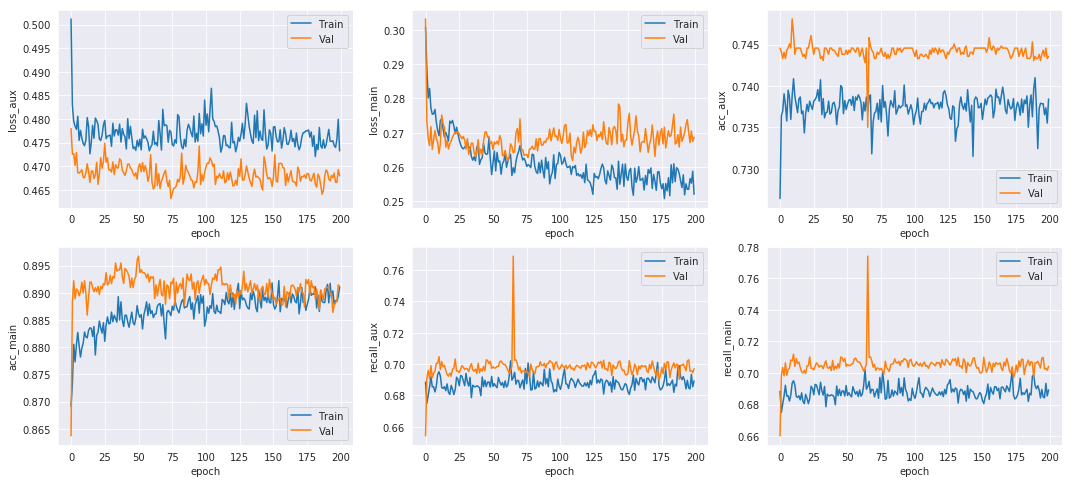

In [33]:
##Chicken cross
show_results_level(model,log.history,df_test_chicken_x,df_test_chicken_emb_x,df_test_chicken_y,256,["loss","acc","recall"])

loss     = 0.4327
aux_loss     = 0.5002
main_loss     = 0.3152
aux_acc     = 0.7057
aux_recall     = 0.6478
main_acc     = 0.8683
main_recall     = 0.6544
['loss', 'aux', 'main']
['aux', 'main']
['aux', 'main']


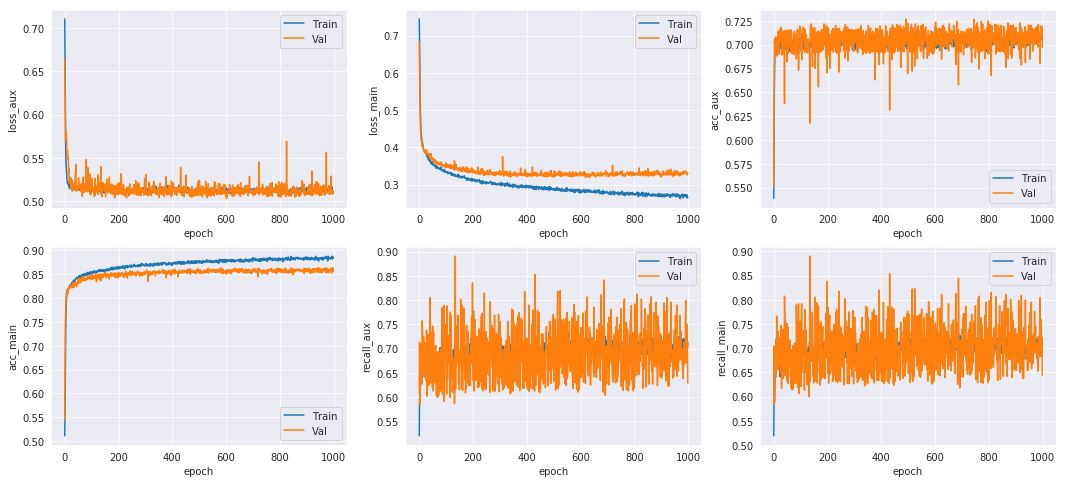

In [57]:
##Chicken
show_results_level(model,log.history,df_test_x,df_test_emb_x,df_test_y,256,["loss","acc","recall"])

loss     = 0.4787
aux_loss     = 0.5738
main_loss     = 0.3462
aux_acc     = 0.6736
aux_recall     = 0.5459
main_acc     = 0.8527
main_recall     = 0.5531
['loss', 'aux', 'main']
['aux', 'main']
['aux', 'main']


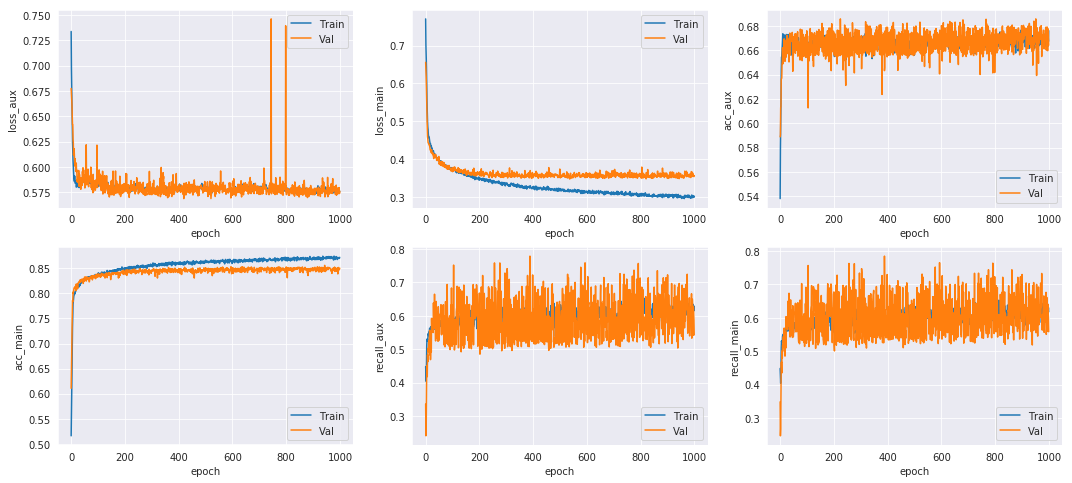

In [74]:
# Mouse
show_results_level(model,log.history,df_test_x,df_test_emb_x,df_test_y,256,["loss","acc","recall"])

In [38]:
df_mouse= dataset_complete[dataset_complete["Specie_Mouse"] == 1]
df_mouse.shape

(2641, 243)

In [39]:
df_test_mouse_x = df_mouse.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_test_mouse_x = df_test_mouse_x.drop(embedding_1_cols,axis=1)
df_test_mouse_x = df_test_mouse_x.drop(embedding_2_cols,axis=1)

df_test_mouse_emb_x =  pd.concat([df_mouse[embedding_1_cols],df_mouse[embedding_2_cols]],axis=1,sort=False)
df_test_mouse_y = df_mouse["Is_Ohnolog"]

loss     = 0.9099
aux_loss     = 0.7918
main_loss     = 0.7338
aux_acc     = 0.1197
aux_recall     = 0.3945
main_acc     = 0.6744
main_recall     = 0.4020
['loss', 'aux', 'main']
['aux', 'main']
['aux', 'main']


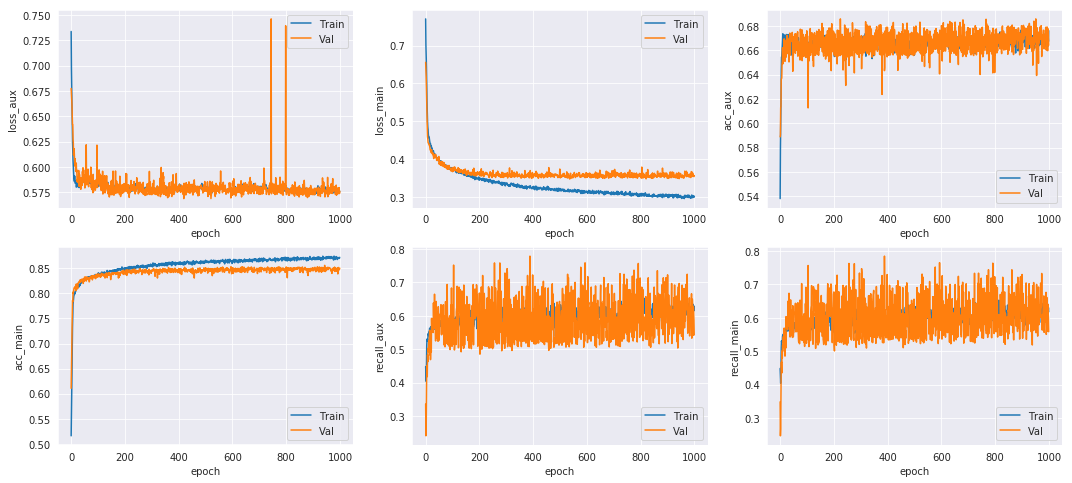

In [90]:
# Mouse normal
show_results_level(model,log.history,df_test_mouse_x,df_test_mouse_emb_x,df_test_mouse_y,256,["loss","acc","recall"])

loss     = 0.7275
aux_loss     = 0.9975
main_loss     = 0.5113
aux_acc     = 0.0000
aux_recall     = 0.3699
main_acc     = 0.7474
main_recall     = 0.3795
['loss', 'aux', 'main']
['aux', 'main']
['aux', 'main']


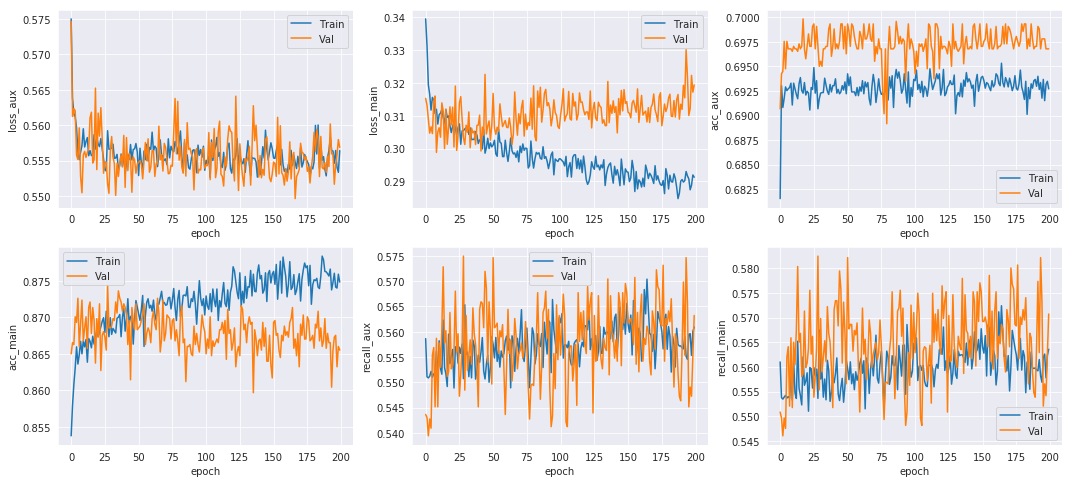

In [40]:
# Mouse cross
show_results_level(model,log.history,df_test_mouse_x,df_test_mouse_emb_x,df_test_mouse_y,256,["loss","acc","recall"])

In [63]:
len(df_train[df_train["Is_Ohnolog"] == 1])/len(df_train)

0.5175013109596225

In [62]:
len(df_chicken[df_chicken["Is_Ohnolog"] == 1])/len(df_chicken)

0.3333333333333333

loss     = 0.6263
aux_loss     = 0.8489
main_loss     = 0.4390
aux_acc     = 0.5086
aux_recall     = 0.8037
main_acc     = 0.8219
main_recall     = 0.8037
['loss', 'aux', 'main']
['aux', 'main']
['aux', 'main']


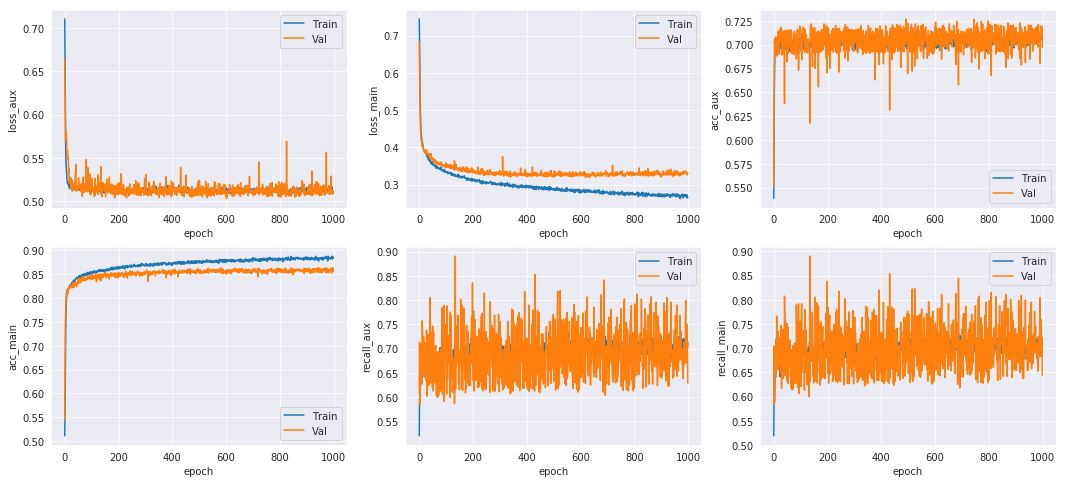

In [61]:
show_results_level(model,log.history,df_test_chicken_x,df_test_chicken_emb_x,df_test_chicken_y,256,["loss","acc","recall"])

In [34]:
df_chicken_ohnologs = df_chicken[df_chicken["Is_Ohnolog"] == 1]
df_chicken_no_ohnologs = df_chicken[df_chicken["Is_Ohnolog"] == 0]
df_chicken_new = df_chicken_ohnologs.append(df_chicken_no_ohnologs.sample(len(df_chicken_ohnologs)))
len(df_chicken_new[df_chicken_new["Is_Ohnolog"] == 1])/len(df_chicken_new)

0.5

In [35]:
df_test_chicken_x = df_chicken_new.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_test_chicken_x = df_test_chicken_x.drop(embedding_1_cols,axis=1)
df_test_chicken_x = df_test_chicken_x.drop(embedding_2_cols,axis=1)

df_test_chicken_emb_x =  pd.concat([df_chicken_new[embedding_1_cols],df_chicken_new[embedding_2_cols]],axis=1,sort=False)
df_test_chicken_y = df_chicken_new["Is_Ohnolog"]

loss     = 0.6662
aux_loss     = 0.7382
main_loss     = 0.5011
aux_acc     = 0.6026
aux_recall     = 0.8037
main_acc     = 0.7941
main_recall     = 0.8037
['loss', 'aux', 'main']
['aux', 'main']
['aux', 'main']


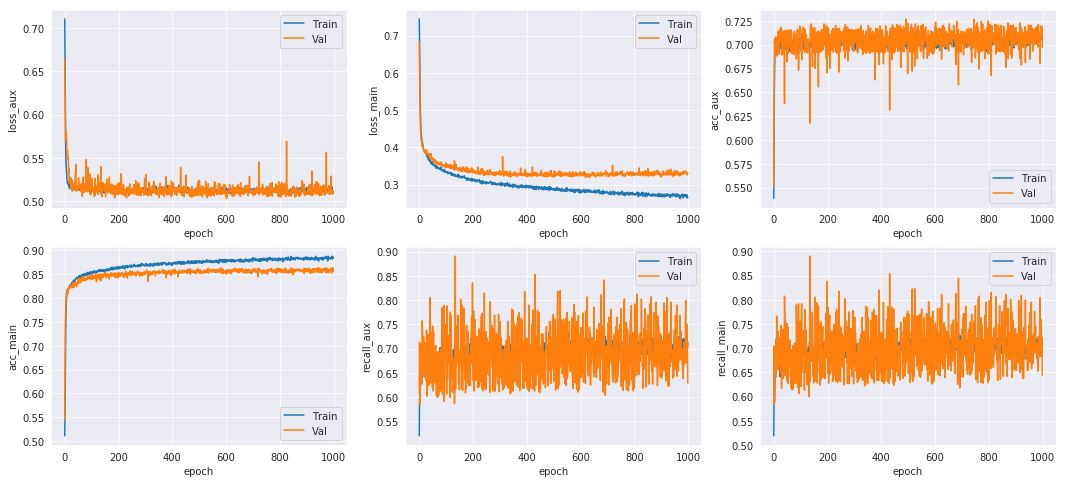

In [67]:
# Chicken Normal
show_results_level(model,log.history,df_test_chicken_x,df_test_chicken_emb_x,df_test_chicken_y,256,["loss","acc","recall"])

loss     = 1.1960
aux_loss     = 1.7112
main_loss     = 0.8380
aux_acc     = 0.5480
aux_recall     = 0.6837
main_acc     = 0.6681
main_recall     = 0.6837
['loss', 'aux', 'main']
['aux', 'main']
['aux', 'main']


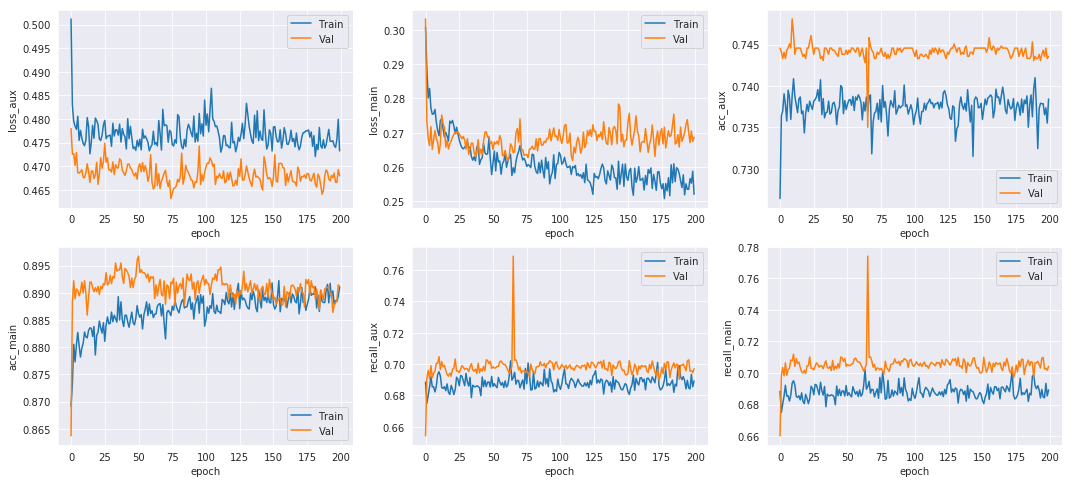

In [36]:
# Chicken cross
show_results_level(model,log.history,df_test_chicken_x,df_test_chicken_emb_x,df_test_chicken_y,256,["loss","acc","recall"])

## Siames

In [92]:
def level_siames_merge_layer(df_meta_input,df_embeddings_1,df_embeddings_2,name,bs):    
    
    input_embedding_1 = Input(shape=(len(df_embeddings_1.columns),), name='embedding_input_1')        
    input_embedding_2 = Input(shape=(len(df_embeddings_2.columns),), name='embedding_input_2')        
    
    emb_x_1 = get_tensor_embedding_layer(input_embedding_1)    
    emb_x_2 = get_tensor_embedding_layer(input_embedding_2)    
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([emb_x_1, emb_x_2])
    
    emb_x_out = Dense(1, activation='sigmoid',name="aux")(L1_distance)                
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')    
    
    x = keras.layers.concatenate([L1_distance,meta_input])
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(1, activation='sigmoid',name="main")(x)
        
    model_created = Model(inputs=[input_embedding_1,input_embedding_2,meta_input], outputs=[predictions,emb_x_out])
    model_created.Name = name
    return model_created

In [93]:
def level_siames_merge_layer_soft(df_meta_input,df_embeddings_1,df_embeddings_2,name,bs):    
    
    input_embedding_1 = Input(shape=(len(df_embeddings_1.columns),), name='embedding_input_1')        
    input_embedding_2 = Input(shape=(len(df_embeddings_2.columns),), name='embedding_input_2')        
    
    emb_x_1 = get_tensor_embedding_layer(input_embedding_1)    
    emb_x_2 = get_tensor_embedding_layer(input_embedding_2)    
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([emb_x_1, emb_x_2])
    
    emb_x_out = Dense(3, activation='softmax',name="aux")(L1_distance)                
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')    
    
    x = keras.layers.concatenate([L1_distance,meta_input])
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(3, activation='softmax',name="main")(x)
        
    model_created = Model(inputs=[input_embedding_1,input_embedding_2,meta_input], outputs=[predictions,emb_x_out])
    model_created.Name = name
    return model_created


In [94]:
def euclidean_distance(x,y):    
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)



In [105]:
def fit_model_siames(train_x,train_emb_x_1,train_emb_x_2,train_y,val_x,val_emb_x_1,val_emb_x_2,val_y,model_train,n_epochs,optimizer,batchsize,loss_weigths,verb):
    tensorboard = TensorBoard(log_dir= train_filepath + working_level + "/board_logs/" + model_train.Name + "-{}".format(time()))
    checkpoint = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-check-{{epoch:02d}}-{{val_main_acc:.2f}}.hdf5".format(model_train.Name),save_weights_only=True,  period = int(n_epochs/5))
    best_model_save = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-best.hdf5".format(model_train.Name), monitor='val_main_acc', save_weights_only=True, save_best_only=True, mode='max')
    logger = EpochLogger(display=25)

    model_train.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy',km.binary_recall()],loss_weights=loss_weigths)    
    return model_train.fit([train_emb_x_1,train_emb_x_2,train_x], y = [train_y,train_y],verbose = verb,validation_data=([val_emb_x_1,val_emb_x_2,val_x],[val_y,val_y]),epochs = n_epochs,batch_size=batchsize,callbacks = [tensorboard,checkpoint,best_model_save,logger])  # starts training


def fit_model_siames_soft(train_x,train_emb_x_1,train_emb_x_2,train_y,val_x,val_emb_x_1,val_emb_x_2,val_y,model_train,n_epochs,optimizer,batchsize,loss_weigths,verb):
    tensorboard = TensorBoard(log_dir=train_filepath + working_level + "/board_logs/" + model_train.Name + "-{}".format(time()))
    checkpoint = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-check-{{epoch:02d}}-{{val_main_acc:.2f}}.hdf5".format(model_train.Name),save_weights_only=True,  period = int(n_epochs/5))
    best_model_save = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-best.hdf5".format(model_train.Name), monitor='val_main_acc', save_weights_only=True, save_best_only=True, mode='max')
    logger = EpochLogger(display=25)

    model_train.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy',km.sparse_categorical_recall()],loss_weights=loss_weigths)    
    return model_train.fit([train_emb_x_1,train_emb_x_2,train_x], y = [train_y,train_y],verbose = verb,validation_data=([val_emb_x_1,val_emb_x_2,val_x],[val_y,val_y]),epochs = n_epochs,batch_size=batchsize,callbacks = [tensorboard,checkpoint,best_model_save,logger])  # starts training

In [96]:
df_train,df_val,df_test = get_train_val_test(dataset_complete_no_chicken)
df_train.head()

,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Is_Ohnolog,Is_Paralog,Sequence-1 GC,Sequence-1 Length,...,Embedding2_91,Embedding2_92,Embedding2_93,Embedding2_94,Embedding2_95,Embedding2_96,Embedding2_97,Embedding2_98,Embedding2_99,Dup_Class
12028,0,1,0,0,0,0,1,0.0,0.499075,0.554254,...,70.493156,-467.235377,-297.770580,-358.897289,-141.311865,-379.257467,134.625360,176.878456,-416.207631,1
6425,0,0,0,0,0,1,0,0.0,0.450886,0.019813,...,9.836120,-84.527801,-9.019162,-69.158747,9.692131,-101.924337,6.945799,10.244836,-91.662070,0
789,0,0,1,0,0,0,1,0.0,0.406405,0.305993,...,17.111708,6.445995,9.925853,-9.159282,92.610158,-14.303605,-33.624520,52.115794,-22.072938,1
1410,0,0,1,0,0,0,1,0.0,0.617035,0.163258,...,-34.432681,43.079047,-27.104744,1.082469,297.361260,-7.758961,-108.415836,149.426719,-22.062287,1
6091,0,0,0,0,0,1,0,1.0,0.513716,0.068953,...,18.728830,-75.277190,0.910015,-69.949224,-4.364673,-101.083151,-1.140520,39.031327,-87.785436,2


In [22]:
df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)

df_train_emb_x_1 = df_train[embedding_1_cols]
df_train_emb_x_2 = df_train[embedding_2_cols]
df_train_y = df_train["Dup_Class"]

df_val_x = df_val.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
df_val_x = df_val_x.drop(embedding_2_cols,axis=1)

df_val_emb_x_1 = df_val[embedding_1_cols]
df_val_emb_x_2 = df_val[embedding_2_cols]                  
df_val_y = df_val["Dup_Class"]

df_test_x = df_test.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_test_x = df_test_x.drop(embedding_1_cols,axis=1)
df_test_x = df_test_x.drop(embedding_2_cols,axis=1)

df_test_emb_x_1 =  df_test[embedding_1_cols]
df_test_emb_x_2 =  df_test[embedding_2_cols]
df_test_y = df_test["Dup_Class"]

In [106]:
df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)

df_train_emb_x_1 = df_train[embedding_1_cols]
df_train_emb_x_2 = df_train[embedding_2_cols]
df_train_y = df_train["Is_Ohnolog"]

df_val_x = df_val.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
df_val_x = df_val_x.drop(embedding_2_cols,axis=1)

df_val_emb_x_1 = df_val[embedding_1_cols]
df_val_emb_x_2 = df_val[embedding_2_cols]                  
df_val_y = df_val["Is_Ohnolog"]

df_test_x = df_test.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_test_x = df_test_x.drop(embedding_1_cols,axis=1)
df_test_x = df_test_x.drop(embedding_2_cols,axis=1)

df_test_emb_x_1 =  df_test[embedding_1_cols]
df_test_emb_x_2 =  df_test[embedding_2_cols]
df_test_y = df_test["Is_Ohnolog"]

In [107]:
model = level_siames_merge_layer(df_train_x,df_train_emb_x_1,df_train_emb_x_2,"Level_model_no_chicken",128)

In [71]:
model = level_siames_merge_layer(df_train_x,df_train_emb_x,"Level_model_no_mouse",128)

In [108]:
log = fit_model_siames(df_train_x.values,df_train_emb_x_1.values,df_train_emb_x_2.values,df_train_y.values,df_val_x.values,df_val_emb_x_1.values,df_val_emb_x_2.values,df_val_y.values,model,1000,Adamax(),256,[1,0.2],0)

step: 25/1000 ...  - loss: 3.9127 - val_loss: 3.7049
 - main_loss: 0.4699 - main_acc: 0.7656 - main_recall: 0.6663 - val_main_loss: 0.4354 - val_main_acc: 0.7894 - val_main_recall: 0.6760
 - aux_loss: 0.5294 - aux_acc: 0.6978 - aux_recall: 0.6657 - val_aux_loss: 0.5246 - val_aux_acc: 0.7049 - val_aux_recall: 0.6706
step: 50/1000 ...  - loss: 0.8861 - val_loss: 0.8862
 - main_loss: 0.3833 - main_acc: 0.8281 - main_recall: 0.7103 - val_main_loss: 0.3893 - val_main_acc: 0.8238 - val_main_recall: 0.6884
 - aux_loss: 0.5143 - aux_acc: 0.7057 - aux_recall: 0.7093 - val_aux_loss: 0.5354 - val_aux_acc: 0.6984 - val_aux_recall: 0.6777
step: 75/1000 ...  - loss: 0.6637 - val_loss: 0.6719
 - main_loss: 0.3610 - main_acc: 0.8401 - main_recall: 0.7201 - val_main_loss: 0.3712 - val_main_acc: 0.8327 - val_main_recall: 0.7158
 - aux_loss: 0.5067 - aux_acc: 0.7102 - aux_recall: 0.7190 - val_aux_loss: 0.5178 - val_aux_acc: 0.7004 - val_aux_recall: 0.7070
step: 100/1000 ...  - loss: 0.6013 - val_loss: 0.

In [112]:
df_test_chicken_x = df_chicken.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_test_chicken_x = df_test_chicken_x.drop(embedding_1_cols,axis=1)
df_test_chicken_x = df_test_chicken_x.drop(embedding_2_cols,axis=1)

df_test_chicken_emb_x_1 =  df_chicken[embedding_1_cols]
df_test_chicken_emb_x_2 =  df_chicken[embedding_2_cols]
df_test_chicken_y = df_chicken["Is_Ohnolog"]

In [ ]:
df_chicken_ohnologs = df_chicken[df_chicken["Is_Ohnolog"] == 1]
df_chicken_no_ohnologs = df_chicken[df_chicken["Is_Ohnolog"] == 0]
df_chicken_new = df_chicken_ohnologs.append(df_chicken_no_ohnologs.sample(len(df_chicken_ohnologs)))
len(df_chicken_new[df_chicken_new["Is_Ohnolog"] == 1])/len(df_chicken_new)

In [ ]:
df_test_chicken_x = df_chicken_new.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_test_chicken_x = df_test_chicken_x.drop(embedding_1_cols,axis=1)
df_test_chicken_x = df_test_chicken_x.drop(embedding_2_cols,axis=1)

df_test_chicken_emb_x_1 =  df_chicken_new[embedding_1_cols]
df_test_chicken_emb_x_2 =  df_chicken_new[embedding_2_cols]
df_test_chicken_y = df_chicken_new["Is_Ohnolog"]

In [113]:
metrics_names,metrics = (model.metrics_names,model.evaluate([df_test_chicken_emb_x_1.values,df_test_chicken_emb_x_2.values,df_test_chicken_x.values],[df_test_chicken_y.values,df_test_chicken_y.values], batch_size=256,verbose=False))
count = 0
for i in range(0,len(metrics)):
    print(f'{metrics_names[i]}     = {metrics[i]:.4f}')            

loss     = 0.9861
main_loss     = 0.6709
aux_loss     = 1.1317
main_acc     = 0.7711
main_recall     = 0.4442
aux_acc     = 0.6146
aux_recall     = 0.4442


In [41]:
def get_tensor_embedding_RNN_layer(input_embedding):    
    emb_x = GRU(128,activation="relu",use_bias=False,recurrent_regularizer=regularizers.l1(0.0005),kernel_regularizer=regularizers.l1(0.005))(input_embedding)  
    emb_x = BatchNormalization()(emb_x)    
    return emb_x

def level_siames_merge_RNN_layer(df_meta_input,df_embeddings_1,df_embeddings_2,name,bs):    
    
    input_embedding_1 = Input(shape=(None,1), name='embedding_input_1')        
    input_embedding_2 = Input(shape=(None,1), name='embedding_input_2')        
    
    emb_x_1 = get_tensor_embedding_RNN_layer(input_embedding_1)    
    emb_x_2 = get_tensor_embedding_RNN_layer(input_embedding_2)    
    
    L1_layer = Lambda(lambda tensors:(tensors[0] - tensors[1]))
    L1_distance = L1_layer([emb_x_1, emb_x_2])
   
    
    emb_x_out = Dense(1, activation='sigmoid',name="aux")(L1_distance)                
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')    
    
    x = keras.layers.concatenate([L1_distance,meta_input])
    x = Dense(256, activation='relu',use_bias=False,kernel_regularizer=regularizers.l1(0.0005))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu',use_bias=False,kernel_regularizer=regularizers.l1(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l1(0.0005))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l1(0.0005))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',kernel_regularizer=regularizers.l1(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu',use_bias=False,kernel_regularizer=regularizers.l1(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(1, activation='sigmoid',name="main")(x)
        
    model_created = Model(inputs=[input_embedding_1,input_embedding_2,meta_input], outputs=[predictions,emb_x_out])
    model_created.Name = name
    return model_created

